<a href="https://colab.research.google.com/github/Vikas-KM/Facial_Expression_Recongition/blob/main/fer_vgg16.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [ ]:
!unzip "/content/drive/My Drive/fer.zip" -d "/content/drive/My Drive/fer"

In [ ]:
train_dir = '/content/drive/MyDrive/fer/images/images/train/'
validation_dir = '/content/drive/MyDrive/fer/images/images/validation/'

In [ ]:
batch_size = 32
img_height = 48
img_width = 48

In [ ]:
train_datagen = ImageDataGenerator(
                                    rescale=1/255, 
                                    rotation_range=40,
                                    width_shift_range=0.2,
                                    height_shift_range=0.2,
                                    shear_range=0.2,
                                    zoom_range=0.2,
                                    horizontal_flip=True,
                                    fill_mode='nearest',) 

In [ ]:
validation_datagen = ImageDataGenerator(rescale=1/255)

In [ ]:
train_generator = train_datagen.flow_from_directory(
                                    directory=train_dir,
                                    shuffle=True,
                                    target_size=(img_height, img_width), 
                                    class_mode='categorical',
                                    color_mode='grayscale',
                                    batch_size=batch_size,)

Found 28821 images belonging to 7 classes.


In [ ]:
validation_generator = validation_datagen.flow_from_directory(
                                    directory=validation_dir,
                                    shuffle=True,
                                    target_size=(img_height, img_width), 
                                    class_mode='categorical',
                                    color_mode='grayscale',
                                    batch_size=batch_size,)

Found 7066 images belonging to 7 classes.


In [ ]:
model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(64, (3, 3), padding='same', activation='relu', input_shape=(img_height, img_width, 1)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2D(64, (3, 3), padding='same', activation='relu', input_shape=(img_height, img_width, 1)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2), strides=2),
    tf.keras.layers.Dropout(0.2),


    tf.keras.layers.Conv2D(128, (3, 3), padding='same',activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2D(128, (3, 3), padding='same',activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Dropout(0.2),

    tf.keras.layers.Conv2D(256, (3, 3), padding='same',activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2D(256, (3, 3), padding='same',activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2D(256, (3, 3), padding='same',activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2), strides=2),
    tf.keras.layers.Dropout(0.2),

    tf.keras.layers.Conv2D(512, (3, 3), padding='same',activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2D(512, (3, 3), padding='same',activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2D(512, (3, 3), padding='same',activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2), strides=2),
    tf.keras.layers.Dropout(0.2),

    tf.keras.layers.Conv2D(512, (3, 3), padding='same',activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2D(512, (3, 3), padding='same',activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2D(512, (3, 3), padding='same',activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2), strides=2),
    tf.keras.layers.Dropout(0.2),

    tf.keras.layers.Flatten(),

    tf.keras.layers.Dense(4096, activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.5),

    tf.keras.layers.Dense(4096, activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.5),


    # tf.keras.layers.Dense(32, activation='relu'),
    # tf.keras.layers.BatchNormalization(),
    # tf.keras.layers.Dropout(0.5),

    tf.keras.layers.Dense(7, activation='softmax')
])

In [ ]:
# model = tf.keras.Sequential([
#     tf.keras.layers.Conv2D(32, (3, 3), padding='same', activation='relu', input_shape=(img_height, img_width, 3)),
#     tf.keras.layers.BatchNormalization(),
#     # tf.keras.layers.Conv2D(64, (3, 3), padding='same', activation='relu', input_shape=(img_height, img_width, 3)),
#     # tf.keras.layers.BatchNormalization(),
#     tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
#     tf.keras.layers.Dropout(0.2),


#     tf.keras.layers.Conv2D(64, (3, 3), padding='same',activation='relu'),
#     tf.keras.layers.BatchNormalization(),
#     # tf.keras.layers.Conv2D(128, (3, 3), padding='same',activation='relu'),
#     # tf.keras.layers.BatchNormalization(),
#     tf.keras.layers.MaxPooling2D(2, 2),
#     tf.keras.layers.Dropout(0.2),

#     tf.keras.layers.Conv2D(64, (3, 3), padding='same',activation='relu'),
#     tf.keras.layers.BatchNormalization(),
#     # tf.keras.layers.Conv2D(256, (3, 3), padding='same',activation='relu'),
#     # tf.keras.layers.BatchNormalization(),
#     # tf.keras.layers.Conv2D(256, (3, 3), padding='same',activation='relu'),
#     tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
#     tf.keras.layers.Dropout(0.2),

#     tf.keras.layers.Conv2D(128, (3, 3), padding='same',activation='relu'),
#     tf.keras.layers.BatchNormalization(),
#     # tf.keras.layers.Conv2D(512, (3, 3), padding='same',activation='relu'),
#     # tf.keras.layers.BatchNormalization(),
#     # tf.keras.layers.Conv2D(512, (3, 3), padding='same',activation='relu'),
#     tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
#     tf.keras.layers.Dropout(0.2),

#     # tf.keras.layers.Conv2D(512, (3, 3), padding='same',activation='relu'),
#     # # tf.keras.layers.BatchNormalization(),
#     # tf.keras.layers.Conv2D(512, (3, 3), padding='same',activation='relu'),
#     # # tf.keras.layers.BatchNormalization(),
#     # tf.keras.layers.Conv2D(512, (3, 3), padding='same',activation='relu'),
#     # tf.keras.layers.MaxPooling2D(pool_size=(2, 2), strides=2),
#     # tf.keras.layers.Dropout(0.2),

#     tf.keras.layers.Flatten(),

#     tf.keras.layers.Dense(64, activation='relu'),
#     # tf.keras.layers.Dense(4096, activation='relu'),
#     # tf.keras.layers.Dense(1024, activation='relu'),

#     tf.keras.layers.BatchNormalization(),
#     tf.keras.layers.Dropout(0.5),

#     tf.keras.layers.Dense(64, activation='relu'),
#     tf.keras.layers.BatchNormalization(),
#     tf.keras.layers.Dropout(0.5),

#     tf.keras.layers.Dense(1, activation='sigmoid')
# ])

In [ ]:
print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 48, 48, 64)        640       
_________________________________________________________________
batch_normalization (BatchNo (None, 48, 48, 64)        256       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 48, 48, 64)        36928     
_________________________________________________________________
batch_normalization_1 (Batch (None, 48, 48, 64)        256       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 24, 24, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 24, 24, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 24, 24, 128)       7

In [ ]:
model.compile(
    loss=tf.keras.losses.categorical_crossentropy,
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
    metrics=['accuracy'],
)

In [ ]:
history = model.fit(
  train_generator,
  validation_data=validation_generator,
  batch_size=batch_size,
  epochs=100,
  verbose=1,
  steps_per_epoch = 900,
  validation_steps = 220,
)

Epoch 1/100
900/900 [==============================] - 72s 71ms/step - loss: 3.1564 - accuracy: 0.1612 - val_loss: 1.8842 - val_accuracy: 0.2347
Epoch 2/100
900/900 [==============================] - 64s 71ms/step - loss: 2.4570 - accuracy: 0.1931 - val_loss: 1.8445 - val_accuracy: 0.2670
Epoch 3/100
900/900 [==============================] - 64s 71ms/step - loss: 2.2052 - accuracy: 0.2073 - val_loss: 1.8178 - val_accuracy: 0.2638
Epoch 4/100
900/900 [==============================] - 64s 71ms/step - loss: 2.1059 - accuracy: 0.2206 - val_loss: 1.8972 - val_accuracy: 0.2885
Epoch 5/100
900/900 [==============================] - 64s 71ms/step - loss: 2.0580 - accuracy: 0.2353 - val_loss: 2.3040 - val_accuracy: 0.3037
Epoch 6/100
900/900 [==============================] - 64s 71ms/step - loss: 2.0222 - accuracy: 0.2429 - val_loss: 2.0037 - val_accuracy: 0.2634
Epoch 7/100
900/900 [==============================] - 63s 70ms/step - loss: 2.0051 - accuracy: 0.2336 - val_loss: 1.9758 - val_ac

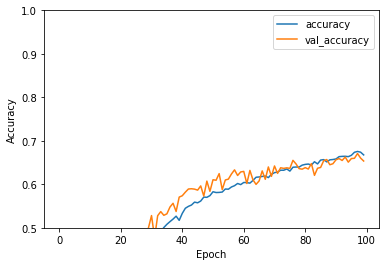

In [ ]:
import matplotlib.pyplot as plt 
%matplotlib inline

plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend()

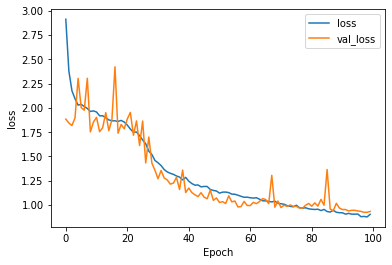

In [ ]:
import matplotlib.pyplot as plt 
%matplotlib inline

plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label = 'val_loss')
plt.xlabel('Epoch')
plt.ylabel('loss')
# plt.ylim([0.5, 1])
plt.legend()